# Handling Missing Values in Data Science

Missing values are a common challenge in real-world datasets. This notebook explores techniques for detecting, visualizing, and handling missing data in pandas DataFrames.

## 1. Import Required Libraries

We'll need several libraries for handling and visualizing missing data:
- pandas and numpy for data manipulation
- matplotlib and seaborn for standard visualization
- missingno for specialized missing data visualization

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Set visualization styles
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Display all dataframe columns
pd.set_option('display.max_columns', None)

## 2. Understanding Missing Values

Missing values in datasets can exist for various reasons:

1. **MCAR (Missing Completely At Random)**: The missing data has no relationship with any values, observed or missing. This is the ideal case for handling missing data.

2. **MAR (Missing At Random)**: The missingness can be explained by other observed variables in the dataset.

3. **MNAR (Missing Not At Random)**: The missingness depends on information that hasn't been recorded.

In pandas, missing values are represented as:
- `NaN` (Not a Number): The standard representation for missing numerical data
- `None`: A Python object often converted to NaN
- `NaT` (Not a Time): Used for missing datetime data

In [2]:
# Generate a sample dataset with different types of missing values
np.random.seed(42)

# Create a sample dataset
df = pd.DataFrame({
    'id': range(1, 1001),
    'age': np.random.normal(35, 10, 1000),
    'income': np.random.normal(50000, 15000, 1000),
    'gender': np.random.choice(['M', 'F'], 1000),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 1000),
    'satisfaction': np.random.choice([1, 2, 3, 4, 5], 1000),
    'join_date': pd.date_range(start='2020-01-01', periods=1000)
})

# Introduce missing values of different types
# MCAR - completely random
df.loc[np.random.choice(df.index, 100, replace=False), 'age'] = np.nan

# MAR - missing based on observed data (e.g., missing income more likely for younger people)
young_indices = df[df['age'] < 30].index
df.loc[np.random.choice(young_indices, int(len(young_indices) * 0.3), replace=False), 'income'] = np.nan

# MNAR - missing not at random (e.g., high income people not reporting satisfaction)
high_income_indices = df[df['income'] > 65000].index
df.loc[np.random.choice(high_income_indices, int(len(high_income_indices) * 0.4), replace=False), 'satisfaction'] = np.nan

# Random missing values in categorical columns
df.loc[np.random.choice(df.index, 50, replace=False), 'gender'] = None
df.loc[np.random.choice(df.index, 80, replace=False), 'education'] = None

# Missing dates
df.loc[np.random.choice(df.index, 70, replace=False), 'join_date'] = pd.NaT

# Display the first few rows of the dataset
df.head()

,id,age,income,gender,education,satisfaction,join_date
0,1,39.967142,70990.331549,F,PhD,3.0,2020-01-01
1,2,33.617357,63869.505244,M,Master,4.0,2020-01-02
2,3,41.476885,50894.455549,F,Master,5.0,2020-01-03
3,4,NaN,40295.948334,M,None,2.0,2020-01-04
4,5,NaN,60473.349704,M,None,3.0,NaT


## 3. Detecting Missing Values

There are several ways to identify missing values in a pandas DataFrame:

- `df.isnull()` or `df.isna()`: Returns a boolean mask where True indicates missing values
- `df.isnull().sum()`: Counts missing values in each column
- `df.info()`: Shows data types and non-null counts
- Calculating percentage of missing values per column

In [3]:
# Check data types and non-null counts
print("DataFrame Information:")
df.info()

# Get the count of missing values in each column
print("\nMissing Value Counts:")
missing_counts = df.isnull().sum()
print(missing_counts)

# Calculate percentage of missing values
print("\nPercentage of Missing Values:")
missing_percentage = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percentage
})
print(missing_summary)

# Check if any rows have all values missing
print(f"\nRows with all values missing: {df.isnull().all(axis=1).sum()}")

# Check if any rows are complete (no missing values)
print(f"Complete rows (no missing values): {(~df.isnull().any(axis=1)).sum()}")

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1000 non-null   int64         
 1   age           900 non-null    float64       
 2   income        918 non-null    float64       
 3   gender        950 non-null    object        
 4   education     920 non-null    object        
 5   satisfaction  936 non-null    float64       
 6   join_date     930 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 54.8+ KB

Missing Value Counts:
id                0
age             100
income           82
gender           50
education        80
satisfaction     64
join_date        70
dtype: int64

Percentage of Missing Values:
              Missing Count  Missing Percentage
id                        0                 0.0
age                     100          

## 4. Visualizing Missing Data

Visualizing missing data patterns can help us better understand:
- The extent of missing data
- Potential relationships between missing values
- Which columns or rows are most affected

We'll use several visualization techniques:
1. Heatmap of missing values
2. Bar chart showing count of missing values per column
3. Matrix plot from the missingno package
4. Dendrogram to identify relationships between missing columns

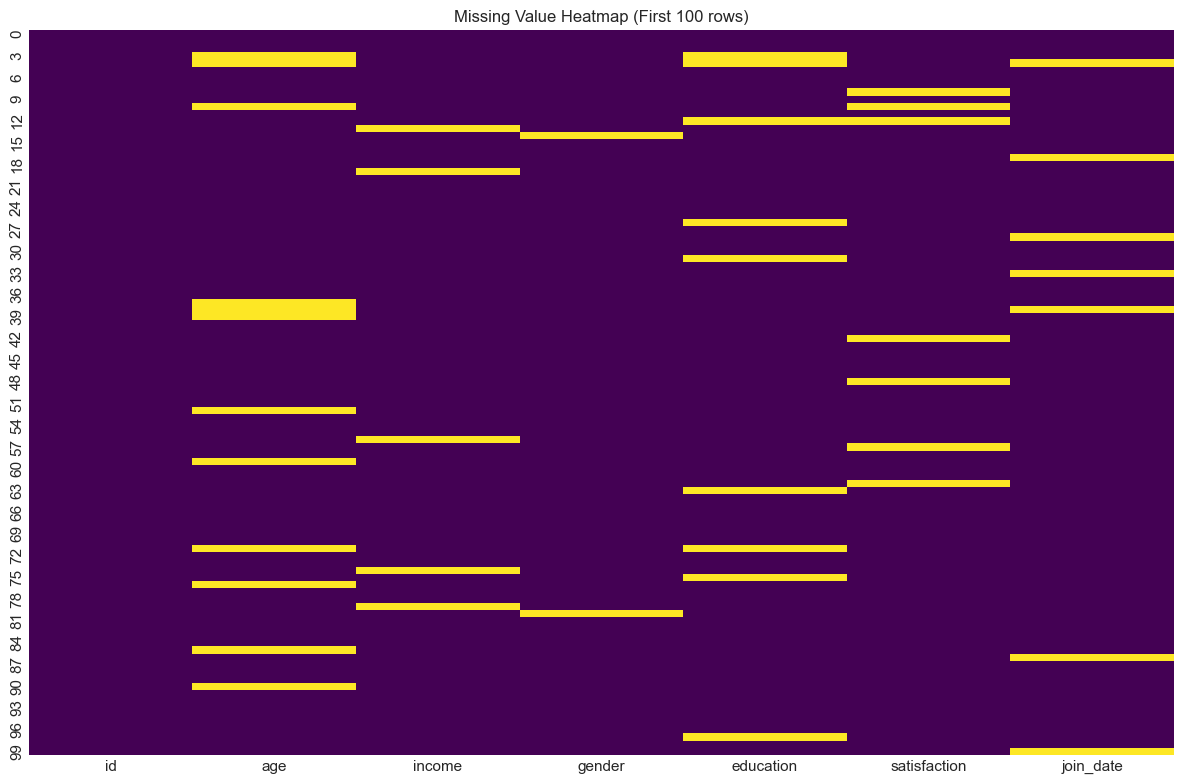

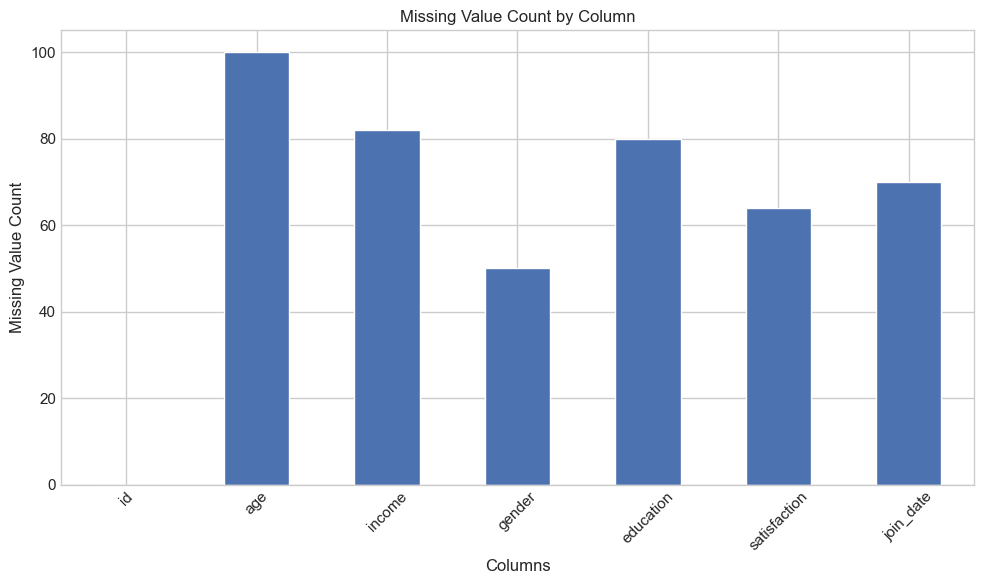

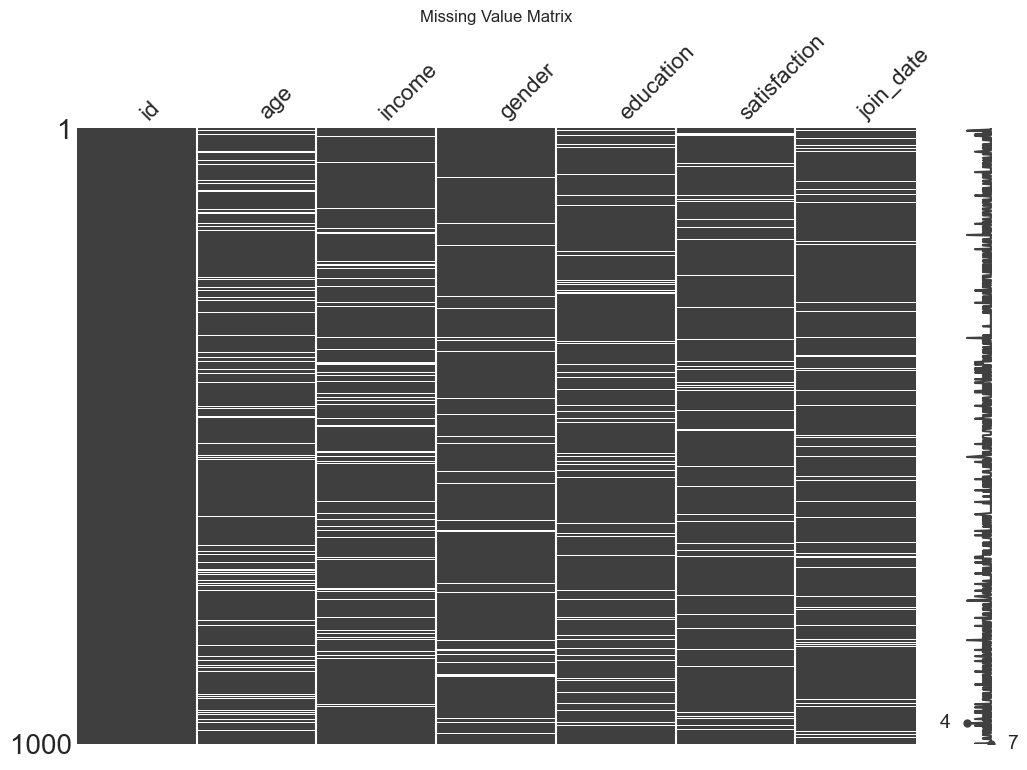

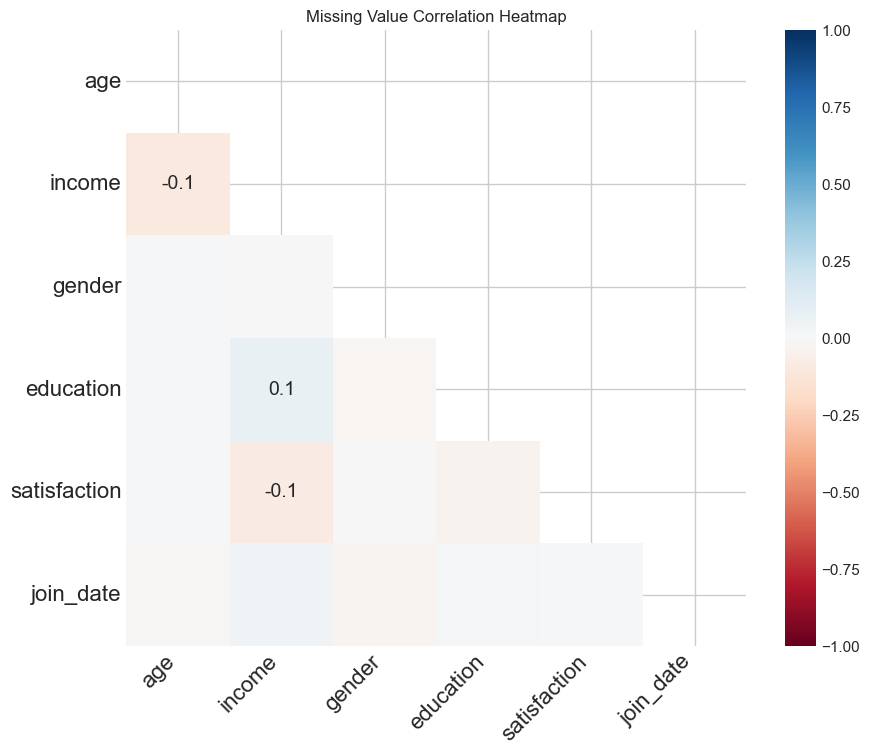

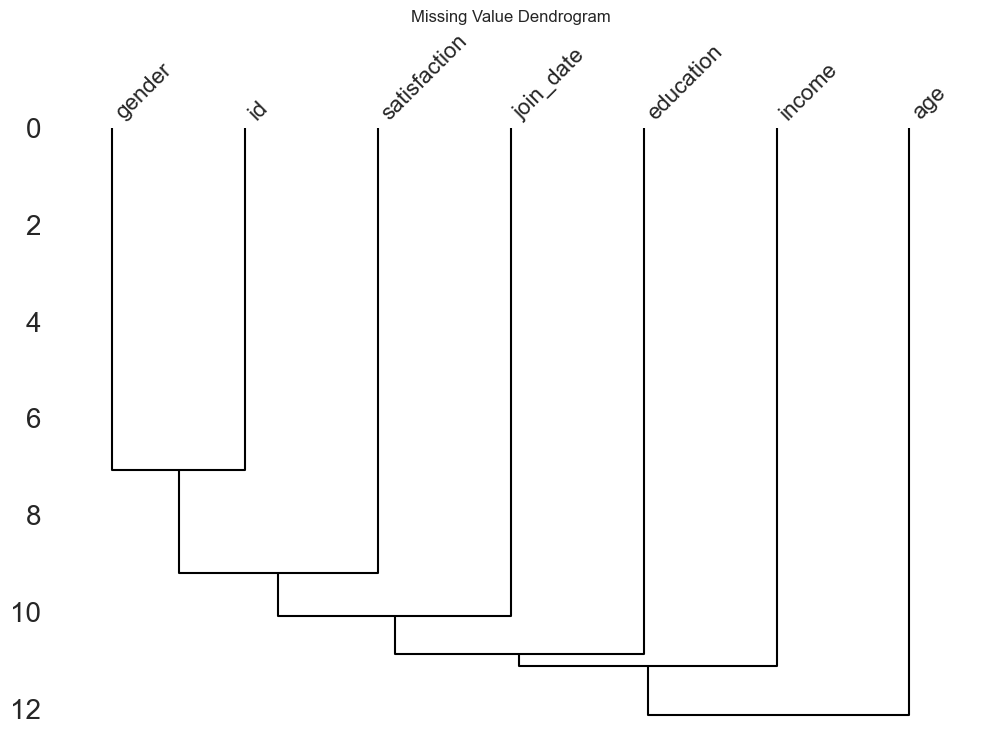

In [4]:
# 1. Heatmap of missing values (for a sample of rows)
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:100].isnull(), cmap='viridis', cbar=False)
plt.title('Missing Value Heatmap (First 100 rows)')
plt.tight_layout()
plt.show()

# 2. Bar chart of missing value counts
plt.figure(figsize=(10, 6))
missing_counts.plot(kind='bar')
plt.title('Missing Value Count by Column')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Missing value matrix with missingno
msno.matrix(df, figsize=(12, 8))
plt.title('Missing Value Matrix')
plt.show()

# 4. Missing value correlation heatmap
msno.heatmap(df, figsize=(10, 8))
plt.title('Missing Value Correlation Heatmap')
plt.show()

# 5. Missing value dendrogram to identify patterns
msno.dendrogram(df, figsize=(12, 8))
plt.title('Missing Value Dendrogram')
plt.show()

## 5. Handling Missing Values

There are several strategies for handling missing values:

1. **Deletion**:
   - Drop rows with missing values
   - Drop columns with too many missing values

2. **Retention**:
   - Keep missing values (some algorithms can handle them directly)
   - Mark missing values with a special category or flag

3. **Imputation**:
   - Fill missing values with calculated or logical values

Let's start with simple deletion and filtering approaches:

In [5]:
# Make a copy of the dataframe to preserve the original
df_handled = df.copy()

# 1. Drop rows with missing values
df_drop_rows = df.dropna()
print(f"Original shape: {df.shape}")
print(f"Shape after dropping rows with missing values: {df_drop_rows.shape}")
print(f"Rows dropped: {df.shape[0] - df_drop_rows.shape[0]}")

# 2. Drop rows with a threshold of missing values
df_drop_thresh = df.dropna(thresh=df.shape[1] - 2)  # Drop rows missing more than 2 values
print(f"Shape after dropping rows missing more than 2 values: {df_drop_thresh.shape}")

# 3. Drop columns with more than 10% missing values
cols_to_drop = missing_percentage[missing_percentage > 10].index
df_drop_cols = df.drop(columns=cols_to_drop)
print(f"Shape after dropping columns with >10% missing values: {df_drop_cols.shape}")
print(f"Columns dropped: {list(cols_to_drop)}")

# 4. Drop specific columns
# df_no_satisfaction = df.drop(columns=['satisfaction'])
# print(f"Shape after dropping 'satisfaction' column: {df_no_satisfaction.shape}")

# 5. Filtering data based on non-missing values in specific columns
df_important_cols = df.dropna(subset=['age', 'income'])
print(f"Shape after keeping only rows with non-missing age and income: {df_important_cols.shape}")

Original shape: (1000, 7)
Shape after dropping rows with missing values: (623, 7)
Rows dropped: 377
Shape after dropping rows missing more than 2 values: (993, 7)
Shape after dropping columns with >10% missing values: (1000, 7)
Columns dropped: []
Shape after keeping only rows with non-missing age and income: (818, 7)


## 6. Imputation Techniques

Imputation involves replacing missing values with substituted values. Here are some common techniques:

1. **Statistical Imputation**:
   - Mean, median, or mode imputation
   - Constant value imputation

2. **Positional Imputation**:
   - Forward fill (carry last valid observation forward)
   - Backward fill (use next valid observation)
   
3. **Group-based Imputation**:
   - Impute based on group statistics

In [6]:
# # Create copies to compare different imputation methods
# df_mean = df.copy()
# df_median = df.copy()
# df_mode = df.copy()
# df_constant = df.copy()
# df_ffill = df.copy()
# df_bfill = df.copy()
# df_group = df.copy()

# # 1. Mean imputation for numerical columns
# df_mean['age'] = df_mean['age'].fillna(df_mean['age'].mean())
# df_mean['income'] = df_mean['income'].fillna(df_mean['income'].mean())
# df_mean['satisfaction'] = df_mean['satisfaction'].fillna(df_mean['satisfaction'].mean())

# # 2. Median imputation for numerical columns
# df_median['age'] = df_median['age'].fillna(df_median['age'].median())
# df_median['income'] = df_median['income'].fillna(df_median['income'].median())
# df_median['satisfaction'] = df_median['satisfaction'].fillna(df_median['satisfaction'].median())

# # 3. Mode imputation for categorical columns
# df_mode['gender'] = df_mode['gender'].fillna(df_mode['gender'].mode()[0])
# df_mode['education'] = df_mode['education'].fillna(df_mode['education'].mode()[0])

# # 4. Constant value imputation
# df_constant['age'] = df_constant['age'].fillna(0)
# df_constant['gender'] = df_constant['gender'].fillna('Unknown')
# df_constant['satisfaction'] = df_constant['satisfaction'].fillna(0)

# # 5. Forward fill (use previous value)
# df_ffill = df_ffill.sort_values('id').fillna(method='ffill')

# # 6. Backward fill (use next value)
# df_bfill = df_bfill.sort_values('id').fillna(method='bfill')

# # 7. Group-based imputation (e.g., fill income based on education level)
# education_groups = df.groupby('education')['income'].transform('mean')
# df_group['income'] = df_group['income'].fillna(education_groups)

# # Compare results of different imputation methods for the income column
# imputation_comparison = pd.DataFrame({
#     'Original': df['income'],
#     'Mean Imputation': df_mean['income'],
#     'Median Imputation': df_median['income'],
#     'Forward Fill': df_ffill['income'],
#     'Backward Fill': df_bfill['income'],
#     'Group-based': df_group['income']
# })

# # Check descriptive statistics of the imputed columns
# print("Descriptive statistics of the imputed income column:")
# imputation_comparison.describe()

```
FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_ffill.sort_values('id').fillna(method='ffill')

FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df_bfill.sort_values('id').fillna(method='bfill')
```

In [7]:
# Create copies to compare different imputation methods
df_mean = df.copy()
df_median = df.copy()
df_mode = df.copy()
df_constant = df.copy()
df_ffill = df.copy()
df_bfill = df.copy()
df_group = df.copy()

# 1. Mean imputation for numerical columns
df_mean['age'] = df_mean['age'].fillna(df_mean['age'].mean())
df_mean['income'] = df_mean['income'].fillna(df_mean['income'].mean())
df_mean['satisfaction'] = df_mean['satisfaction'].fillna(df_mean['satisfaction'].mean())

# 2. Median imputation for numerical columns
df_median['age'] = df_median['age'].fillna(df_median['age'].median())
df_median['income'] = df_median['income'].fillna(df_median['income'].median())
df_median['satisfaction'] = df_median['satisfaction'].fillna(df_median['satisfaction'].median())

# 3. Mode imputation for categorical columns
df_mode['gender'] = df_mode['gender'].fillna(df_mode['gender'].mode()[0])
df_mode['education'] = df_mode['education'].fillna(df_mode['education'].mode()[0])

# 4. Constant value imputation
df_constant['age'] = df_constant['age'].fillna(0)
df_constant['gender'] = df_constant['gender'].fillna('Unknown')
df_constant['satisfaction'] = df_constant['satisfaction'].fillna(0)

# 5. Forward fill (use previous value)
df_ffill = df_ffill.sort_values('id').ffill()

# 6. Backward fill (use next value)
df_bfill = df_bfill.sort_values('id').bfill()

# 7. Group-based imputation (e.g., fill income based on education level)
education_groups = df.groupby('education')['income'].transform('mean')
df_group['income'] = df_group['income'].fillna(education_groups)

# Compare results of different imputation methods for the income column
imputation_comparison = pd.DataFrame({
    'Original': df['income'],
    'Mean Imputation': df_mean['income'],
    'Median Imputation': df_median['income'],
    'Forward Fill': df_ffill['income'],
    'Backward Fill': df_bfill['income'],
    'Group-based': df_group['income']
})

# Check descriptive statistics of the imputed columns
print("Descriptive statistics of the imputed income column:")
imputation_comparison.describe()

Descriptive statistics of the imputed income column:


,Original,Mean Imputation,Median Imputation,Forward Fill,Backward Fill,Group-based
count,918.000000,1000.000000,1000.000000,1000.000000,1000.000000,988.000000
mean,50829.910458,50829.910458,50798.871763,50949.059748,50870.225356,50858.097893
std,14960.895753,14333.739933,14334.116529,14988.704137,14945.363510,14424.939645
min,5894.170480,5894.170480,5894.170480,5894.170480,5894.170480,5894.170480
25%,40815.945444,41797.031553,41797.031553,40907.492726,40876.331887,41729.692644
50%,50451.389798,50829.910458,50451.389798,50480.062236,50589.463770,50555.357842
75%,60623.825819,59473.294755,59473.294755,60677.407858,60628.862595,59538.374399
max,97896.613518,97896.613518,97896.613518,97896.613518,97896.613518,97896.613518


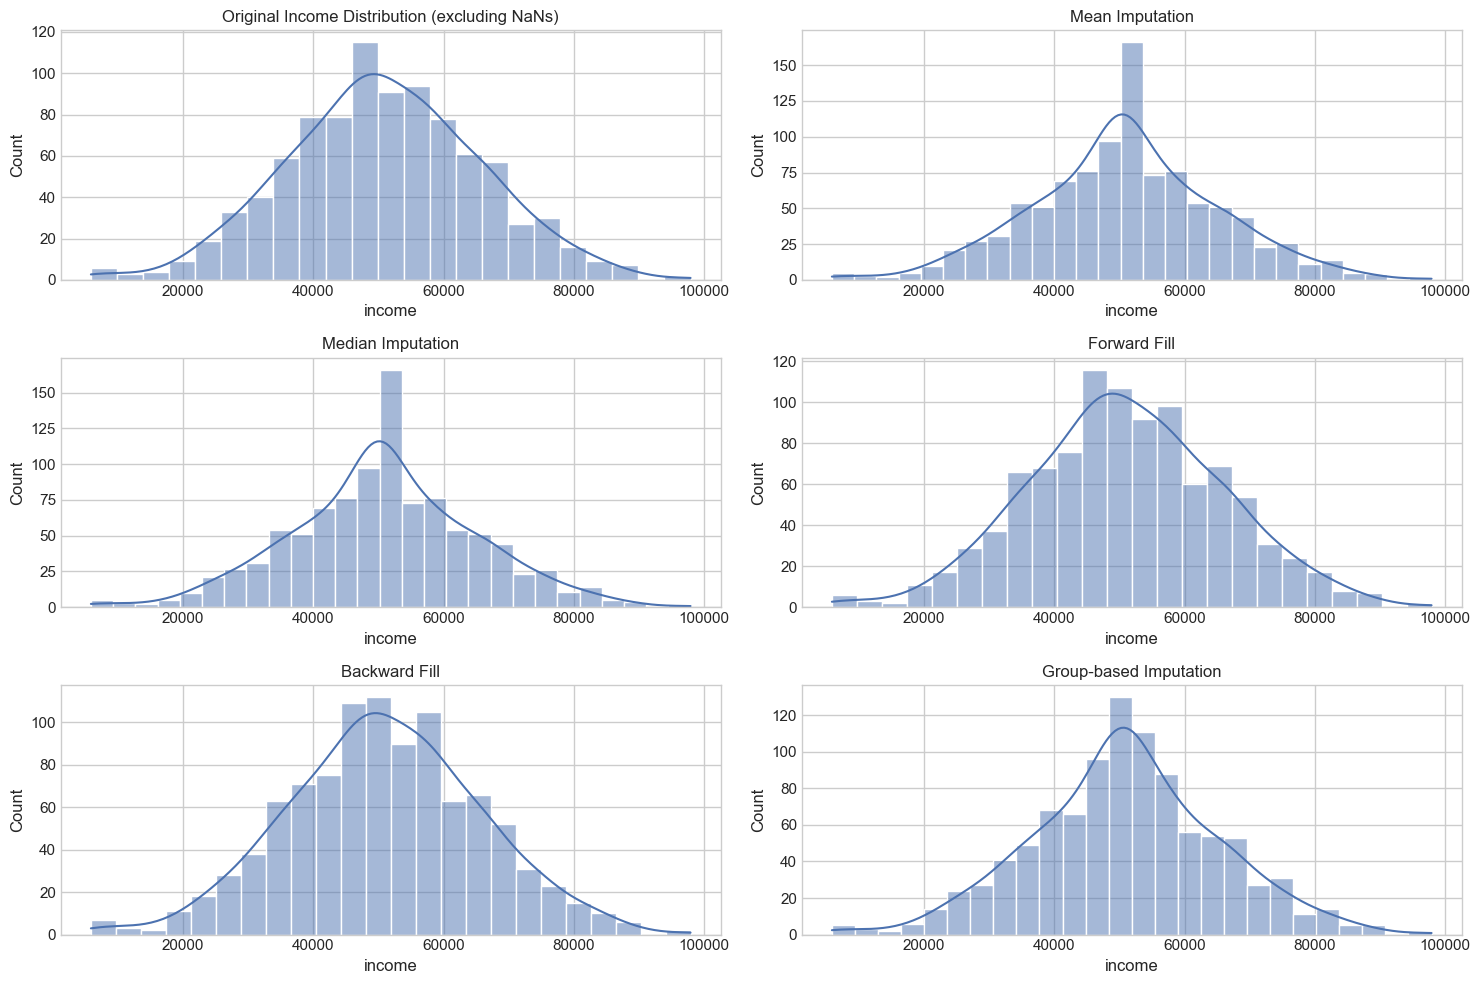

In [8]:
# Visualize the effect of different imputation methods on the distribution
plt.figure(figsize=(15, 10))

# Original distribution (excluding NaNs)
plt.subplot(3, 2, 1)
sns.histplot(df['income'].dropna(), kde=True)
plt.title("Original Income Distribution (excluding NaNs)")

# Mean imputation
plt.subplot(3, 2, 2)
sns.histplot(df_mean['income'], kde=True)
plt.title("Mean Imputation")

# Median imputation
plt.subplot(3, 2, 3)
sns.histplot(df_median['income'], kde=True)
plt.title("Median Imputation")

# Forward fill
plt.subplot(3, 2, 4)
sns.histplot(df_ffill['income'], kde=True)
plt.title("Forward Fill")

# Backward fill
plt.subplot(3, 2, 5)
sns.histplot(df_bfill['income'], kde=True)
plt.title("Backward Fill")

# Group-based imputation
plt.subplot(3, 2, 6)
sns.histplot(df_group['income'], kde=True)
plt.title("Group-based Imputation")

plt.tight_layout()
plt.show()

## 7. Advanced Imputation Methods

For more sophisticated imputation, we can use:

1. **KNN Imputation**: Imputes values based on k-nearest neighbors
2. **Iterative Imputation**: Uses relationships between features to predict missing values
3. **MICE (Multiple Imputation by Chained Equations)**: Creates multiple imputations based on the patterns in the data

These methods are available in scikit-learn.

In [9]:
# from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
# from sklearn.experimental import enable_iterative_imputer  # needed for IterativeImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# # Create a copy of the dataframe
# df_advanced = df.copy()

# # Separate numerical and categorical columns
# numerical_cols = ['age', 'income', 'satisfaction']
# categorical_cols = ['gender', 'education']

# # Create categorical variables for non-missing data (for visualization)
# df_num = df[numerical_cols].copy()

# # 1. Simple Imputer (Mean strategy)
# simple_imputer = SimpleImputer(strategy='mean')
# df_simple_imputed = pd.DataFrame(
#     simple_imputer.fit_transform(df_num),
#     columns=numerical_cols
# )

# # 2. KNN Imputer
# knn_imputer = KNNImputer(n_neighbors=5)
# df_knn_imputed = pd.DataFrame(
#     knn_imputer.fit_transform(df_num),
#     columns=numerical_cols
# )

# # 3. Iterative Imputer (Multivariate imputation)
# iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
# df_iterative_imputed = pd.DataFrame(
#     iterative_imputer.fit_transform(df_num),
#     columns=numerical_cols
# )

# # Compare results for the income column
# imputation_comparison_advanced = pd.DataFrame({
#     'Original': df['income'],
#     'Simple Imputer (Mean)': df_simple_imputed['income'],
#     'KNN Imputer': df_knn_imputed['income'],
#     'Iterative Imputer': df_iterative_imputed['income']
# })

# # Visualize the effect of different advanced imputation methods
# plt.figure(figsize=(15, 8))

# # Original distribution (excluding NaNs)
# plt.subplot(2, 2, 1)
# sns.histplot(df['income'].dropna(), kde=True)
# plt.title("Original Income Distribution (excluding NaNs)")

# # Simple Imputer (Mean)
# plt.subplot(2, 2, 2)
# sns.histplot(df_simple_imputed['income'], kde=True)
# plt.title("Simple Imputer (Mean)")

# # KNN Imputer
# plt.subplot(2, 2, 3)
# sns.histplot(df_knn_imputed['income'], kde=True)
# plt.title("KNN Imputer")

# # Iterative Imputer
# plt.subplot(2, 2, 4)
# sns.histplot(df_iterative_imputed['income'], kde=True)
# plt.title("Iterative Imputer")

# plt.tight_layout()
# plt.show()

```
ImportError: IterativeImputer is experimental and the API might change without any deprecation cycle. To use it, you need to explicitly import enable_iterative_imputer:
from sklearn.experimental import enable_iterative_imputer
```

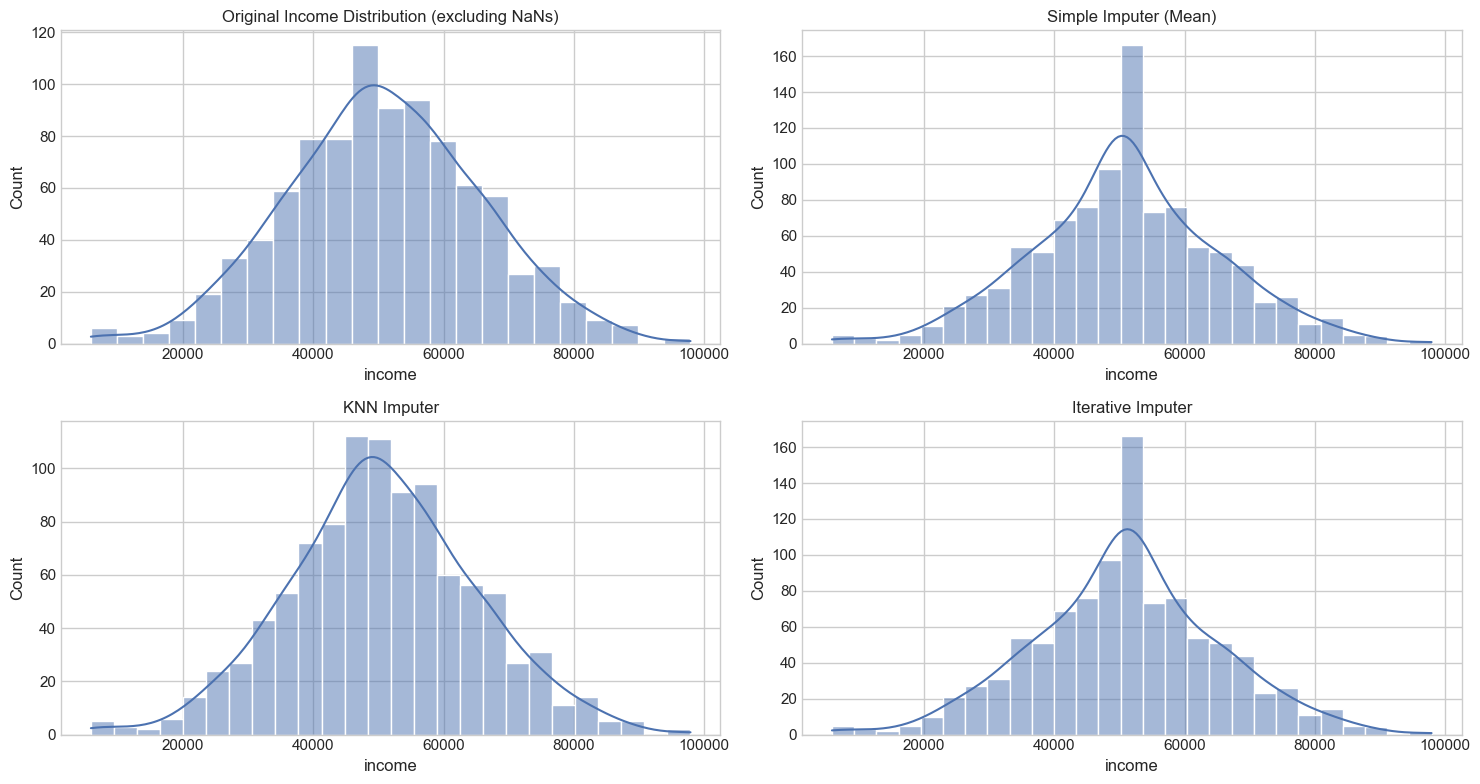

In [10]:
from sklearn.experimental import enable_iterative_imputer  # must come first
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the dataframe
df_advanced = df.copy()

# Separate numerical and categorical columns
numerical_cols = ['age', 'income', 'satisfaction']
categorical_cols = ['gender', 'education']

# Create categorical variables for non-missing data (for visualization)
df_num = df[numerical_cols].copy()

# 1. Simple Imputer (Mean strategy)
simple_imputer = SimpleImputer(strategy='mean')
df_simple_imputed = pd.DataFrame(
    simple_imputer.fit_transform(df_num),
    columns=numerical_cols
)

# 2. KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_num),
    columns=numerical_cols
)

# 3. Iterative Imputer (Multivariate imputation)
iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
df_iterative_imputed = pd.DataFrame(
    iterative_imputer.fit_transform(df_num),
    columns=numerical_cols
)

# Compare results for the income column
imputation_comparison_advanced = pd.DataFrame({
    'Original': df['income'],
    'Simple Imputer (Mean)': df_simple_imputed['income'],
    'KNN Imputer': df_knn_imputed['income'],
    'Iterative Imputer': df_iterative_imputed['income']
})

# Visualize the effect of different advanced imputation methods
plt.figure(figsize=(15, 8))

# Original distribution (excluding NaNs)
plt.subplot(2, 2, 1)
sns.histplot(df['income'].dropna(), kde=True)
plt.title("Original Income Distribution (excluding NaNs)")

# Simple Imputer (Mean)
plt.subplot(2, 2, 2)
sns.histplot(df_simple_imputed['income'], kde=True)
plt.title("Simple Imputer (Mean)")

# KNN Imputer
plt.subplot(2, 2, 3)
sns.histplot(df_knn_imputed['income'], kde=True)
plt.title("KNN Imputer")

# Iterative Imputer
plt.subplot(2, 2, 4)
sns.histplot(df_iterative_imputed['income'], kde=True)
plt.title("Iterative Imputer")

plt.tight_layout()
plt.show()

## 8. Evaluating Imputation Effectiveness

To evaluate the effectiveness of different imputation methods, we can:

1. Introduce artificial missing values in a complete dataset
2. Apply different imputation methods
3. Compare the imputed values with the original "true" values

Metrics to evaluate imputation:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Effect on statistical properties (mean, variance, correlations)
- Impact on downstream analysis (e.g., predictive models)

Imputation Method Comparison:
   Method       MAE      RMSE
0    Mean  6.396717  8.232162
1  Median  6.391388  8.228265
2   Group  6.408794  8.267124
3     KNN  7.551487  9.603333


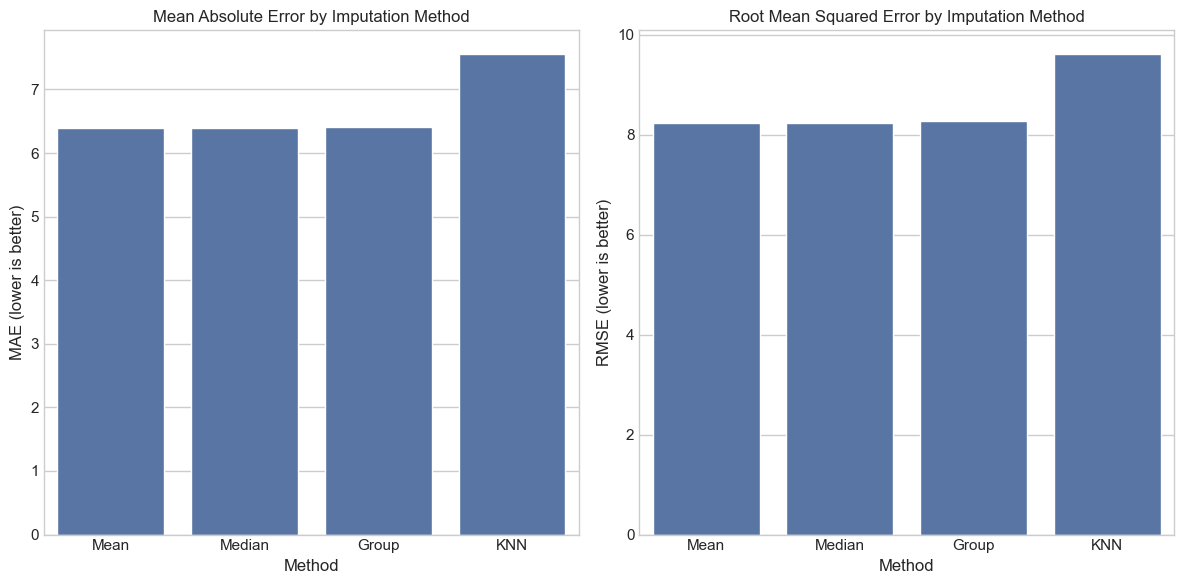

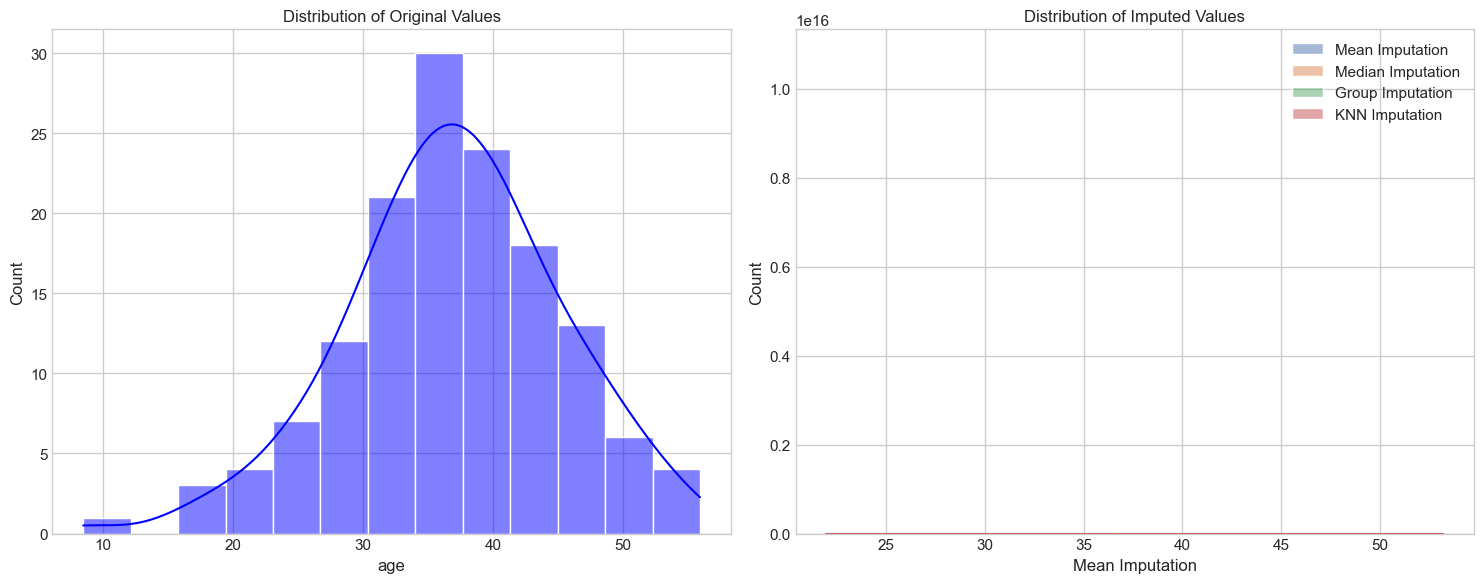

In [11]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer  # ← Add this line
import math


# Create a complete dataset (only keeping rows with no missing values)
df_complete = df.dropna().reset_index(drop=True)

if len(df_complete) > 0:
    # Make a copy to introduce artificial missing values
    df_test = df_complete.copy()
    
    # Randomly introduce missing values (20% of age values)
    np.random.seed(42)
    mask = np.random.rand(len(df_test)) < 0.2
    
    # Save the true values before making them missing
    true_values = df_test.loc[mask, 'age'].copy()
    
    # Set values as missing
    df_test.loc[mask, 'age'] = np.nan
    
    # Apply different imputation methods
    # Mean imputation
    df_mean_imp = df_test.copy()
    df_mean_imp['age'] = df_mean_imp['age'].fillna(df_mean_imp['age'].mean())
    
    # Median imputation
    df_median_imp = df_test.copy()
    df_median_imp['age'] = df_median_imp['age'].fillna(df_median_imp['age'].median())
    
    # Group-based imputation (by gender)
    df_group_imp = df_test.copy()
    gender_means = df_test.groupby('gender')['age'].transform('mean')
    df_group_imp['age'] = df_group_imp['age'].fillna(gender_means)
    
    # KNN imputation
    df_knn_imp = df_test.copy()
    # Only impute age column with KNN
    cols_for_knn = ['age', 'income', 'satisfaction']  # Using these features for KNN
    knn_imputer = KNNImputer(n_neighbors=3)
    df_knn_array = knn_imputer.fit_transform(df_test[cols_for_knn])
    df_knn_imp['age'] = df_knn_array[:, 0]  # Take imputed age column
    
    # Evaluate the imputation methods
    imputation_results = pd.DataFrame({
        'True Values': true_values,
        'Mean Imputation': df_mean_imp.loc[mask, 'age'].values,
        'Median Imputation': df_median_imp.loc[mask, 'age'].values,
        'Group Imputation': df_group_imp.loc[mask, 'age'].values,
        'KNN Imputation': df_knn_imp.loc[mask, 'age'].values
    })
    
    # Calculate error metrics
    imputation_errors = pd.DataFrame({
        'Method': ['Mean', 'Median', 'Group', 'KNN'],
        'MAE': [
            mean_absolute_error(true_values, df_mean_imp.loc[mask, 'age']),
            mean_absolute_error(true_values, df_median_imp.loc[mask, 'age']),
            mean_absolute_error(true_values, df_group_imp.loc[mask, 'age']),
            mean_absolute_error(true_values, df_knn_imp.loc[mask, 'age'])
        ],
        'RMSE': [
            math.sqrt(mean_squared_error(true_values, df_mean_imp.loc[mask, 'age'])),
            math.sqrt(mean_squared_error(true_values, df_median_imp.loc[mask, 'age'])),
            math.sqrt(mean_squared_error(true_values, df_group_imp.loc[mask, 'age'])),
            math.sqrt(mean_squared_error(true_values, df_knn_imp.loc[mask, 'age']))
        ]
    })
    
    # Print results
    print("Imputation Method Comparison:")
    print(imputation_errors)
    
    # Visualize the error comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Method', y='MAE', data=imputation_errors)
    plt.title('Mean Absolute Error by Imputation Method')
    plt.ylabel('MAE (lower is better)')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Method', y='RMSE', data=imputation_errors)
    plt.title('Root Mean Squared Error by Imputation Method')
    plt.ylabel('RMSE (lower is better)')
    
    plt.tight_layout()
    plt.show()
    
    # Compare original and imputed distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(true_values, kde=True, color='blue', label='True Values')
    plt.title('Distribution of Original Values')
    
    plt.subplot(1, 2, 2)
    methods = ['Mean Imputation', 'Median Imputation', 'Group Imputation', 'KNN Imputation']
    for method in methods:
        sns.histplot(imputation_results[method], kde=True, alpha=0.5, label=method)
    plt.title('Distribution of Imputed Values')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough complete data to perform imputation evaluation.")

## 9. Best Practices and Summary

### Summary of Missing Value Handling Approaches:

1. **Understanding missing data**:
   - Identify the type of missingness (MCAR, MAR, MNAR)
   - Visualize missing data patterns
   - Calculate the extent of missingness

2. **Consider the impact of missing data**:
   - On sample size
   - On variable distributions
   - On relationships between variables

3. **Choose the appropriate handling method**:
   - For MCAR: Simple imputation may be sufficient
   - For MAR: More advanced imputation using relationships in data
   - For MNAR: Requires careful consideration and domain knowledge

4. **Evaluate imputation effectiveness**:
   - Compare statistical properties before and after imputation
   - Assess impact on downstream analysis
   - Consider using multiple imputation methods for sensitivity analysis

### Best Practices:

- Document all decisions made regarding missing data
- Consider creating "missingness indicators" as additional features
- Be aware of the bias that imputation can introduce
- Use domain knowledge to guide imputation strategies
- For critical analyses, consider how missing data handling affects results

In [12]:
# Create a summary of imputation methods and their pros/cons
imputation_methods = pd.DataFrame({
    'Method': [
        'Deletion (listwise)',
        'Deletion (pairwise)',
        'Mean/Median/Mode',
        'Forward/Backward Fill',
        'Group-based',
        'KNN Imputation',
        'Iterative Imputation',
        'Multiple Imputation'
    ],
    'Description': [
        'Remove entire rows with any missing values',
        'Remove specific columns or use available data for each analysis',
        'Replace with column average (mean/median) or most common value (mode)',
        'Use adjacent values (temporal or sequential)',
        'Impute based on similar groups (e.g., by gender, age group)',
        'Impute based on similarity to other samples',
        'Use relationships between features to predict missing values',
        'Create multiple complete datasets with different imputations'
    ],
    'Best Used When': [
        'Very few missing values, MCAR assumption holds',
        'Different analyses can use different variables',
        'MCAR data, simple approach needed, numerical data',
        'Time series data, sequential data with trends',
        'Strong group patterns exist, categorical predictors',
        'Complex relationships, enough complete cases for similarity',
        'Strong relationships between variables, complex patterns',
        'Accounting for uncertainty in imputation, formal statistical inference'
    ],
    'Limitations': [
        'Reduces sample size, potential loss of information, bias if not MCAR',
        'Complex to implement, different N for different analyses',
        'Reduces variance, doesn\'t preserve relationships, unrealistic',
        'Requires sensible ordering, may not be realistic',
        'Requires good grouping variables, may have small group sizes',
        'Computationally intensive, requires parameter tuning',
        'Assumes relationships between variables, complex to implement',
        'Computationally intensive, complex to implement and analyze'
    ]
})

# Display the summary table
imputation_methods

,Method,Description,Best Used When,Limitations
0,Deletion (listwise),Remove entire rows with any missing values,"Very few missing values, MCAR assumption holds","Reduces sample size, potential loss of informa..."
1,Deletion (pairwise),Remove specific columns or use available data ...,Different analyses can use different variables,"Complex to implement, different N for differen..."
2,Mean/Median/Mode,Replace with column average (mean/median) or m...,"MCAR data, simple approach needed, numerical data","Reduces variance, doesn't preserve relationshi..."
3,Forward/Backward Fill,Use adjacent values (temporal or sequential),"Time series data, sequential data with trends","Requires sensible ordering, may not be realistic"
4,Group-based,"Impute based on similar groups (e.g., by gende...","Strong group patterns exist, categorical predi...","Requires good grouping variables, may have sma..."
5,KNN Imputation,Impute based on similarity to other samples,"Complex relationships, enough complete cases f...","Computationally intensive, requires parameter ..."
6,Iterative Imputation,Use relationships between features to predict ...,"Strong relationships between variables, comple...","Assumes relationships between variables, compl..."
7,Multiple Imputation,Create multiple complete datasets with differe...,"Accounting for uncertainty in imputation, form...","Computationally intensive, complex to implemen..."


## Conclusion

Handling missing values is a critical step in the data preprocessing pipeline. The approach you choose depends on:

1. The amount and pattern of missingness
2. The underlying mechanism of the missing data
3. The requirements of your analysis
4. The computational resources available

Remember that there is no one-size-fits-all solution. Each dataset and analysis might require a different approach, and it's often valuable to try multiple methods and compare their effects on your results.

By properly addressing missing values, you can build more robust and reliable models while minimizing bias and preserving as much information as possible from your data.